# Demonstration of EM-VAMP with adaptive shrinkage (ash) prior

- toc: true
- badges: true
- comments: true
- categories: [em-vamp, ash, self-study]
- slug: em-vamp-ash-demo

### About

In this demo, I illustrate how to use the [vampyre](https://github.com/GAMPTeam/vampyre) package for sparse multiple linear regression. We consider a simple linear model,

$\mathbf{y} = \mathbf{X}\mathbf{b} + \mathbf{w}$,

$\mathbf{w} \sim \mathcal{N}\left(\mathbf{0} \mid \sigma^2 I_n \right)$,

$\mathbf{b} \sim p\left(\mathbf{b} \mid \boldsymbol{\theta}_1\right)$.

Here $\mathbf{y}$ is a vector of length $n$, $\mathbf{X}$ is a matrix of size $n \times p$ and $\mathbf{b}$ is a vector of length $p$. 
The goal is to estimate the posterior $p\left(\mathbf{b} \mid \mathbf{y}\right)$. 
Generally, the priors $\boldsymbol{\theta}_1$ and $\sigma$ are also unknown and need to be estimated.
The VAMP ([Vector Approximate Message Passing](https://ieeexplore.ieee.org/document/8713501)) algorithm estimates the posterior when the priors are known.
The EM-VAMP algorithm proposed by [Fletcher and Schniter, 2017](https://ieeexplore.ieee.org/document/7952957) combines VAMP and Expectation Maximization to estimate both the prior and the posterior. The EM-VAMP algorithm, among others, is implemented in [vampyre](https://github.com/GAMPTeam/vampyre).

In this example, I will use two different class of priors for the regression:
1. **Spike-and-slab**. $p\left(b_i \mid \boldsymbol{\theta}_1\right) = (1 - \pi) \delta(b_i) + \pi \mathcal{N}\left(b_i \mid \mu_b, \sigma_b\right)$
2. **ash**. $p\left(b_i \mid \boldsymbol{\theta}_1\right) = \sum_{k=1}^{K} \pi_k \mathcal{N}\left(b_i \mid \mu_k, \sigma_k\right)$ with a constraint $\sum_{k=1}^{K} \pi_k = 1$. We will assume $(\mu_k, \sigma_k)$ is known for all $k$, and will estimate the $\pi_k$ from the data.

### Importing packages

First, we need to import the `vampyre` package. [PyMir](https://github.com/banskt/pymir) is a personal Python package where I keep some helper functions of matplotlib for using across all projects. This can be skipped and all instances of `pymir` can be commented out to use the default settings of `matplotlib`.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import vampyre
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

### Generating synthetic data

We generate sparse synthetic data for analyzing the regresison methods.

In [2]:
def simulate (n, p, s, pve = 0.5, rho = 0, seed = None):
    ''' 
    X is sampled from a multivariate normal, with covariance matrix S.
    S has unit diagonal entries and constant off-diagonal entries rho.
    Inputs:
        n = number of samples
        p = number of predictors
        s = number of non-zero predictors
        pve = proportion of variance in y explained by Xb
        rho = correlation in the off-diagonal entries of X
        seed
    Outputs:
        X     = matrix of predictors (size n x p)
        y     = vector of responses (size n)
        Xtest, ytest = holdout test set
        beta  = coefficientss
        se    = sigma (standard deviation of w in the model)
    '''
    iidX       = np.random.normal(size = n * 2 * p).reshape(n * 2, p)
    comR       = np.random.normal(size = n * 2).reshape(n * 2, 1)
    Xall       = comR * np.sqrt(rho) + iidX * np.sqrt(1 - rho)
    # split into training and test data
    X          = Xall[:n, :]
    Xtest      = Xall[n:, :]
    # sample betas
    bidx       = np.random.choice(p, s, replace = False)
    beta       = np.zeros(p)
    beta[bidx] = np.random.normal(size = s)
    # obtain sd from pve
    se         = np.sqrt(np.var(np.dot(X, beta)) * (1 - pve) / pve)
    # calculate the responses
    y          = np.dot(X,     beta) + se * np.random.normal(size = n)
    ytest      = np.dot(Xtest, beta) + se * np.random.normal(size = n)
    return X, y, Xtest, ytest, beta, se

# Simulation parameters
n = 100
p = 200
s = 10
pve = 0.5
rho = 0
X, y, Xtest, ytest, beta, se = simulate(n, p, s, pve = pve, rho = rho)

print (f"Data generated with n = {n}, p = {p}, s = {s}, pve = {pve}, rho = {rho}.")
print (f"Calculated input sigma = {se:.3f}")

Data generated with n = 100, p = 200, s = 10, pve = 0.5, rho = 0.
Calculated input sigma = 3.042


### Set up the EM-VAMP solver

The EM-VAMP estimator requires that we specify two probability distributions:
 - **Prior**:  $p\left(\mathbf{b} \mid \boldsymbol{\theta}_1\right)$;
 - **Likelihood**: $p\left(\mathbf{y} \mid \mathbf{b}, \sigma\right) = \mathcal{N}\left(\mathbf{y} \mid \mathbf{X}\mathbf{b}, \sigma^2 I_n\right)$

Both the `spike-and-slab` and `ash` prior can be represented by Gaussian mixtures. Hence I will set up EM-VAMP with GMM estimators (note that some other estimators are also implemented in `vampyre`). The parameters $\mathbf{\theta}_1$ will be represented by the components (`probc`, `meanc`, `varc`), respectively the proportion, mean and variance of each Gaussian component in the mixture. For the likelihood, the unknown parameter $\sigma^2$ is the output variance `wvar`.

EM-VAMP estimation allows to learn the values of the parameters $\theta_1$ and $\sigma^2$ while also estimating the posterior expectation of the vector $\mathbf{b}$.

In [3]:
def vamp_solver(X, y, probc, meanc, varc, sigma2_init, max_iter, 
                tune_wvar = True, tune_gmm = True, 
                mean_fix = None, var_fix = None):
    n, p      = X.shape
    bshape    = (p, 1)
    Xop       = vampyre.trans.MatrixLT(X, bshape)
    # flag indicating if the estimator uses MAP estimation (else use MMSE).
    map_est   = False
    # Use Gaussian mixture estimator class with auto-tuning
    # Enables EM tuning of the GMM parameters.
    # In this case, probc, meanc and varc are used as initial estimates
    # zvarmin - minimum variance in each cluster
    est_in_em  = vampyre.estim.GMMEst(shape = bshape,
                                      zvarmin = 1e-6, tune_gmm = tune_gmm,
                                      probc = probc, meanc = meanc, varc = varc,
                                      name = 'GMM input', mean_fix = mean_fix, var_fix = var_fix)

    est_out_em = vampyre.estim.LinEst(Xop, y, wvar = sigma2_init,
                                      map_est = map_est, tune_wvar = tune_wvar,
                                      name = 'Linear+AWGN')
    # Create the message handler
    msg_hdl    = vampyre.estim.MsgHdlSimp(map_est = map_est, shape = bshape)
    # Create the solver
    solver     = vampyre.solver.Vamp(est_in_em, est_out_em, msg_hdl, hist_list=['zhat'],
                                     nit = max_iter, prt_period = 0)
    # Run the solver
    solver.solve()
    return solver


# Some ad-hoc initialization of the Gaussian Mixture Model (GMM)
def vamp_initialize(X, probc, meanc, varc, sigma2_init):
    n, p         = X.shape
    # How many components?
    if not all(x is None for x in [probc, meanc, varc]):
        clist = [len(x) for x in [probc, meanc, varc] if x is not None]
        ncomp = clist[0]
        assert all(x==clist[0] for x in clist), "Different lengths for initial GMM prob / mean / var"
    else:
        ncomp     = 2 
    # Proportion of each component
    if probc is None:
        prob_hi   = np.minimum(n / p / 2, 0.95)
        probc     = np.zeros(ncomp)
        probc[1:] = np.repeat(prob_hi / (ncomp - 1), (ncomp - 1)) 
        probc[0]  = 1 - np.sum(probc[1:])
    # Mean of each component
    if meanc is None:
        meanc     = np.zeros(ncomp)
    # Variance of each component
    if varc is None:
        var_hi    = sigma2_init / (np.mean(np.abs(X)**2) * p * np.sum(probc[1:]))
        var_hi    = max(var_hi, 0.1)
        varc      = var_hi * np.arange(ncomp) / (ncomp - 1)
        varc[0]   = var_hi * 1e-4 # the first component cannot be zero.
    return probc, meanc, varc

def fit_em_vamp(X, y, max_iter = 10000,
                probc = None, meanc = None, varc = None,
                mean_fix = None, var_fix = None):
    
    # Center y and add intercept
    # It is redundant to do both.
    ymean = np.mean(y)
    Xc    = np.concatenate((np.ones((X.shape[0], 1)),  X), axis = 1)
    yc    = (y - ymean).reshape(-1, 1)

    # Initial sigma2 is set to the variance of y (mean centered).
    sigma2_init = np.mean(yc**2)

    # Initial probc, meanc, varc
    probc, meanc, varc = vamp_initialize(Xc, probc, meanc, varc, sigma2_init)

    # Get the estimation history
    solver = vamp_solver(Xc, yc, probc, meanc, varc, sigma2_init, max_iter, 
                         mean_fix = mean_fix, var_fix = var_fix)
    bhat_hist = solver.hist_dict['zhat']

    for bhat in bhat_hist:
        bhat[0] += ymean
    bopt = bhat_hist[-1].reshape(-1)
    return bhat_hist, bopt[0], bopt[1:]

def get_rmse(X, y, bhist):
    niter = len(bhist)
    rmse  = np.zeros(niter)
    n, p = X.shape
    for it in range(niter):
        bhati    = bhist[it]
        ypred    = np.dot(Xtest, bhati[1:]) + bhati[0]
        rmse[it] = np.sqrt(np.mean((ytest.reshape(n,1) - ypred)**2))
    return rmse

To estimate VAMP with ash prior, we initialize the components as in Mr.ASH

In [4]:
ash_ncomp    = 10
ash_probc    = np.ones(ash_ncomp) / ash_ncomp
ash_meanc    = np.zeros(ash_ncomp)
ash_varc     = (4**(np.arange(ash_ncomp)/ash_ncomp) - 1)**2
ash_varc[0]  = 1e-4 
ash_mean_fix = np.ones(ash_ncomp)
ash_var_fix  = np.ones(ash_ncomp)

### Run the solvers

In [5]:
max_iter = 100
emvamp_bhist, emvamp_mu, emvamp_beta = fit_em_vamp(X, y, max_iter = max_iter)
emvamp_rmse = get_rmse(Xtest, ytest, emvamp_bhist)

print (f"Final RMSE (EM-VAMP): {emvamp_rmse[-1]:.3f}")

Final RMSE (EM-VAMP): 3.444


In [6]:

ash_emvamp_bhist, ash_emvamp_mu, ash_emvamp_beta = fit_em_vamp(X, y, max_iter = max_iter,
    probc = ash_probc, meanc = ash_meanc, varc  = ash_varc,
    mean_fix = ash_mean_fix, var_fix  = ash_var_fix)

ash_emvamp_rmse = get_rmse(Xtest, ytest, ash_emvamp_bhist)

print (f"Final RMSE (EM-VAMP-ASH): {ash_emvamp_rmse[-1]:.3f}")

Final RMSE (EM-VAMP-ASH): 3.453


### View Results

We plot the two RMSE as a function of the iteration number

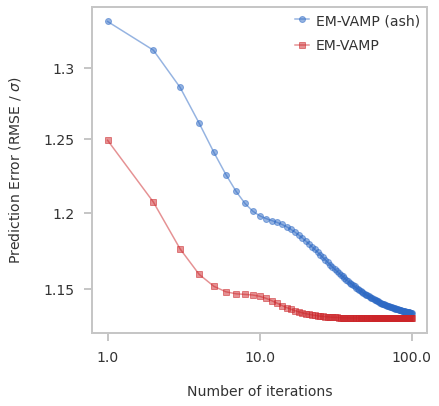

In [7]:
# My presentation style. Switch off if not using PyMir.
mpl_stylesheet.banskt_presentation(dpi = 72)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

xvals = np.log10(1 + np.arange(emvamp_rmse.shape[0]))

ax1.plot(xvals, np.log10(ash_emvamp_rmse / se), 'o-', alpha = 0.5)
ax1.plot(xvals, np.log10(emvamp_rmse / se), 's-', alpha = 0.5)
        
ax1.legend(['EM-VAMP (ash)', 'EM-VAMP'])
ax1.set_ylabel(r"Prediction Error (RMSE / $\sigma$)")
ax1.set_xlabel(r"Number of iterations")

ax1.tick_params(labelcolor = "#333333")
# Magic ticks Switch off if not using PyMir.
mpl_utils.set_yticks(ax1, kmin = 4, kmax = 6, scale = 'log10')
mpl_utils.set_xticks(ax1, kmin = 4, kmax = 6, scale = 'log10', spacing = 'log10')

plt.show()